In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')
df_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
df_test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
df_item = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
df_item_cat = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
df_shop = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')

df_train.shape, df_test.shape, df_item.shape, df_item_cat.shape, df_shop.shape

((2935849, 6), (214200, 3), (22170, 3), (84, 2), (60, 2))

In [3]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
df_item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
df_item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
df_shop.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


<AxesSubplot:xlabel='item_cnt_day'>

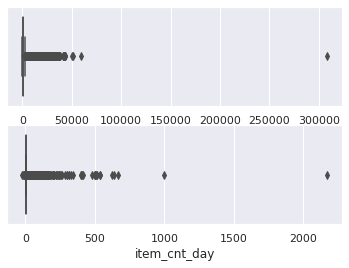

In [7]:
fig, axs = plt.subplots(2)

sns.boxplot(ax=axs[0], x=df_train['item_price'])
sns.boxplot(ax=axs[1], x=df_train['item_cnt_day'])

In [8]:
# Droping the outliers and set all the 'item_cnt_day < 1' to 0
drop_index = df_train[(df_train['item_price']>300000) | (df_train['item_price']<0) | (df_train['item_cnt_day']>999)].index
df_train.drop(index=drop_index, inplace=True)
df_train.loc[df_train['item_cnt_day']<1, 'item_cnt_day'] = 0

In [9]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [10]:
# Find intersection between test and train dataset
df_test_shop_unique = df_test['shop_id'].unique()
df_test_item_unique = df_test['item_id'].unique()

df_train = df_train[df_train['shop_id'].isin(df_test_shop_unique)]
df_train = df_train[df_train['item_id'].isin(df_test_item_unique)]

print('Train dataset size after: {}'.format(df_train.shape[0]))

Train dataset size after: 1224437


In [11]:
# Create categorical feature in df_item_cat and df_shop
from sklearn.preprocessing import LabelEncoder

item_group = df_item_cat['item_category_name'].str.split(' ').map(lambda x:x[0])
print(item_group.unique())
df_item_cat['item_group'] = LabelEncoder().fit_transform(item_group)

df_item_cat

['PC' 'Аксессуары' 'Билеты' 'Доставка' 'Игровые' 'Игры' 'Карты' 'Кино'
 'Книги' 'Музыка' 'Подарки' 'Программы' 'Служебные' 'Чистые' 'Элементы']


,item_category_name,item_category_id,item_group
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1
...,...,...,...
79,Служебные,79,12
80,Служебные - Билеты,80,12
81,Чистые носители (шпиль),81,13
82,Чистые носители (штучные),82,13


In [12]:
city_group = df_shop['shop_name'].str.split(' ').map(lambda x:x[0])
print(city_group.unique())
df_shop['city'] = LabelEncoder().fit_transform(city_group)
df_shop.head()

['!Якутск' 'Адыгея' 'Балашиха' 'Волжский' 'Вологда' 'Воронеж' 'Выездная'
 'Жуковский' 'Интернет-магазин' 'Казань' 'Калуга' 'Коломна' 'Красноярск'
 'Курск' 'Москва' 'Мытищи' 'Н.Новгород' 'Новосибирск' 'Омск'
 'РостовНаДону' 'СПб' 'Самара' 'Сергиев' 'Сургут' 'Томск' 'Тюмень' 'Уфа'
 'Химки' 'Цифровой' 'Чехов' 'Якутск' 'Ярославль']


,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,0
2,"Адыгея ТЦ ""Мега""",2,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,2
4,"Волжский ТЦ ""Волга Молл""",4,3


In [13]:
# Merge
df_train = df_train.merge(df_item, on='item_id', how='left')
df_train = df_train.merge(df_item_cat, on='item_category_id', how='left')
df_train = df_train.merge(df_shop, on='shop_id', how='left')
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,item_group,shop_name,city
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,7,"Ярославль ТЦ ""Альтаир""",31
1,03.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,9,"Москва ТРК ""Атриум""",14
2,05.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,9,"Москва ТРК ""Атриум""",14
3,07.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,9,"Москва ТРК ""Атриум""",14
4,08.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,9,"Москва ТРК ""Атриум""",14
...,...,...,...,...,...,...,...,...,...,...,...,...
1224432,10.10.2015,33,25,7409,299.0,1.0,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,9,"Москва ТРК ""Атриум""",14
1224433,09.10.2015,33,25,7460,299.0,1.0,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,9,"Москва ТРК ""Атриум""",14
1224434,14.10.2015,33,25,7459,349.0,1.0,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,9,"Москва ТРК ""Атриум""",14
1224435,22.10.2015,33,25,7440,299.0,1.0,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,9,"Москва ТРК ""Атриум""",14


In [14]:
df_test = df_test.merge(df_item, on='item_id', how='left')
df_test = df_test.merge(df_item_cat, on='item_category_id', how='left')
df_test = df_test.merge(df_shop, on='shop_id', how='left')
df_test['date_block_num'] = 34
df_test.drop(columns='ID', inplace=True)
df_test

,shop_id,item_id,item_name,item_category_id,item_category_name,item_group,shop_name,city,date_block_num
0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,5,"Вологда ТРЦ ""Мармелад""",4,34
1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,9,"Вологда ТРЦ ""Мармелад""",4,34
2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,5,"Вологда ТРЦ ""Мармелад""",4,34
3,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,5,"Вологда ТРЦ ""Мармелад""",4,34
4,5,5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4,5,"Вологда ТРЦ ""Мармелад""",4,34
...,...,...,...,...,...,...,...,...,...
214195,45,18454,СБ. Союз 55,55,Музыка - CD локального производства,9,"Самара ТЦ ""ПаркХаус""",21,34
214196,45,16188,Настольная игра Нано Кёрлинг,64,Подарки - Настольные игры,10,"Самара ТЦ ""ПаркХаус""",21,34
214197,45,15757,НОВИКОВ АЛЕКСАНДР Новая коллекция,55,Музыка - CD локального производства,9,"Самара ТЦ ""ПаркХаус""",21,34
214198,45,19648,ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,Кино - DVD,7,"Самара ТЦ ""ПаркХаус""",21,34


In [15]:
monthly_sale = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']}).reset_index()
monthly_sale.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']

df = pd.concat([df_train, df_test])
df = df.merge(monthly_sale, on=['date_block_num', 'shop_id', 'item_id'], how='left')
df['item_cnt_month'] = df['item_cnt_month'].fillna(0)
df.drop(columns=['date', 'item_name', 'item_category_name', 'shop_name', 'item_cnt_day', 'item_price'], inplace=True)
df

,date_block_num,shop_id,item_id,item_category_id,item_group,city,item_cnt_month
0,0,59,22154,37,7,31,1.0
1,0,25,2574,55,9,14,13.0
2,0,25,2574,55,9,14,13.0
3,0,25,2574,55,9,14,13.0
4,0,25,2574,55,9,14,13.0
...,...,...,...,...,...,...,...
1438632,34,45,18454,55,9,21,0.0
1438633,34,45,16188,64,10,21,0.0
1438634,34,45,15757,55,9,21,0.0
1438635,34,45,19648,40,7,21,0.0


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train = df[df['date_block_num']<34]
test = df[df['date_block_num']==34]

X = train.drop(columns=['item_cnt_month'])
y = train['item_cnt_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((857105, 6), (367332, 6), (857105,), (367332,))

In [17]:
# Modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_pred, squared=False)
lr_r2 = r2_score(y_test, lr_pred)

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_rmse = mean_squared_error(y_test, dt_pred, squared=False)
dt_r2 = r2_score(y_test, dt_pred)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
rf_r2 = r2_score(y_test, rf_pred)

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_rmse = mean_squared_error(y_test, gb_pred, squared=False)
gb_r2 = r2_score(y_test, gb_pred)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
xgb_r2 = r2_score(y_test, xgb_pred)

lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
lgbm_pred = xgb.predict(X_test)
lgbm_rmse = mean_squared_error(y_test, lgbm_pred, squared=False)
lgbm_r2 = r2_score(y_test, lgbm_pred)

summary_dict = {'RMSE': [lr_rmse, dt_rmse, rf_rmse, gb_rmse, xgb_rmse, lgbm_rmse],
                'R2 score': [lr_r2, dt_r2, rf_r2, gb_r2, xgb_r2, lgbm_r2]}

summary = pd.DataFrame(data=summary_dict, index=['Linear regression', 'Decision Tree', 'Random forest', 'Gradient boosting', 'XGBRegressor', 'LGBMRegressor'])
summary

,RMSE,R2 score
Linear regression,35.646705,0.043840
Decision Tree,1.276008,0.998775
Random forest,1.233758,0.998855
Gradient boosting,22.901640,0.605338
XGBRegressor,10.042369,0.924114
LGBMRegressor,10.042369,0.924114


In [18]:
test.drop(columns=['item_cnt_month'], inplace=True)
final_pred = rf.predict(test)
test_pred = pd.DataFrame(final_pred, columns=['item_cnt_month'])
test_pred

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,item_cnt_month
0,2.02
1,1.94
2,2.30
3,1.13
4,1.94
...,...
214195,1.08
214196,1.01
214197,1.31
214198,1.29


In [19]:
# Get the 'Id' column from the original test dataset
# Combine 'Id' and the prediction into a new dataframe
test_id = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')['ID']

result = pd.concat([test_id, test_pred], axis=1)
result.head()

,ID,item_cnt_month
0,0,2.02
1,1,1.94
2,2,2.30
3,3,1.13
4,4,1.94


In [20]:
result.to_csv('submission.csv', index=False)